# Mock Data Pipeline

`scippr` requires inputs in the form of catalogs $\{p(t_{n}, z_{n}, \mu_{n} | \underline{\ell}_{n}, \vec{m}_{n}, \underline{\phi}^{*}, \vec{\theta}^{*})\}_{N}$ of interim posteriors expressed as `3D` arrays constituting probabilities over $t_{n}$, $z_{n}$, and $\mu_{n}$, enabling rapid computation of the posterior $p(\underline{\phi}, \vec{\theta} | \{\underline{\ell}_{n}, \vec{m}_{n}\}_{N})$ over the hyperparameters $\underline{\phi}$ and $\vec{\theta}$ of scientific interest.  This notebook outlines a procedure for generating such a catalog.

Perhaps the defining feature of this pipeline is that it does not involve simulating supernova lightcurves or host galaxy photometry and instead simulating the interim posteriors directly.  There are several good reasons for this choice:

* The motivation for `scippr` is to develop a method for doing inference with accurate probability distributions over relevant supernova parameters, not to develop methods for obtaining those probability distributions.
* We avoid tying our inference method to a particular way of deriving interim posteriors from observed data.
* We avoid making assumptions about the details of the observed data, such as the photometric filters, intrinsic lightcurves, and observing conditions.

In [2]:
import daft
import astropy.cosmology as cosmology

import numpy as np
import bisect
import sys
import scipy.stats as sps
import scipy.optimize as spo

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rc
rc("font", family="serif", size=12)
rc("text", usetex=True)

colors = 'rbgcymk'

`scippr` is based on a probabilistic graphical model, illustrated below.  The model has two types of observables, shown in shaded circles, supernova lightcurves $\underline{\ell}_{n}$ and host galaxy photometry $\vec{m}_{n}$.  The parameters, which are by definition not directly observable, are shown in empty circles.  The latent variables of supernova type $t_{n}$, redshift $z_{n}$, and distance modulus $\mu_{n}$ are parameters over which we will marginalize, without ever directly inferring them, and while all three of them influence $\underline{\ell}_{n}$, only $z_{n}$ affects $\vec{m}_{n}$ in this model.  In other words, _we currently assume no relationship between supernova type and host galaxy photometry, an assumption we may revisit in the future_.  The selection functions parametrized by $\underline{C}_{\underline{\ell}}$ and $\vec{C}_{\vec{\ell}}$ are known constants of the survey symbolized by dots that influence the possible lightcurves and host galaxy photometry that are included in the sample.  The box indicates that the latent variables and the observables are generated independently $N$ times for each supernova in the sample.  The hyperparameters we would like to estimate are the redshift-dependent supernova type proportions $\underline{\phi}$ that determine $t_{n}$ and $z_{n}$ and the cosmological parameters $\vec{\theta}$ that relate $z_{n}$ to $\mu_{n}$, which are shared by all $N$ supernovae.  

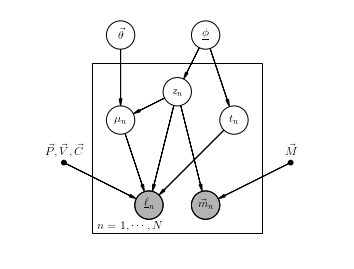

In [11]:
#initialize the PGM
pgm = daft.PGM([6, 4.5], origin=[0, 0])

#desired hyperparameters
pgm.add_node(daft.Node("cosmology", r"$\vec{\theta}$", 2., 4.))
pgm.add_node(daft.Node("dist", r"$\underline{\phi}$", 3.5, 4.))
#pgm.add_node(daft.Node("rates", r"$\vec{R}$", 3., 5.5, fixed=True))

#latent variables/parameters
pgm.add_node(daft.Node("distance", r"$\mu_{n}$", 2., 2.5))
pgm.add_node(daft.Node("redshift", r"$z_{n}$", 3., 3.))
pgm.add_node(daft.Node("type", r"$t_{n}$", 4., 2.5))

#data
pgm.add_node(daft.Node("lightcurve", r"$\underline{\ell}_{n}$", 2.5, 1., observed=True))
pgm.add_node(daft.Node("photometry", r"$\vec{m}_{n}$", 3.5, 1., observed=True))

#known constant parameters
pgm.add_node(daft.Node("lightcurve selection", r"$\vec{P}, \vec{V}, \vec{C}$", 1., 1.75, fixed=True))
pgm.add_node(daft.Node("photometry selection", r"$\vec{M}$", 5., 1.75, fixed=True))

# Add in the edges.
pgm.add_edge("dist", "type")
pgm.add_edge("cosmology", "distance")
pgm.add_edge("dist", "redshift")
pgm.add_edge("redshift", "distance")
#pgm.add_edge("distance", "photometry")
pgm.add_edge("distance", "lightcurve")
pgm.add_edge("redshift", "photometry")
pgm.add_edge("redshift", "lightcurve")
pgm.add_edge("type", "lightcurve")
pgm.add_edge("photometry selection", "photometry")
pgm.add_edge("lightcurve selection", "lightcurve")

# plates
pgm.add_plate(daft.Plate([1.5, 0.5, 3., 3.], label=r"$n = 1, \cdots, N$"))

# Render and save.
pgm.render()
pgm.figure.show()

To simulate a mock catalog for `scippr`, there are three main steps.

1. Choose true values for the hyperparameters, which we would like to recover from our inference, and the parameters, over which we intend to marginalize.
2. Create likelihoods based on a model for how they are derived from observations under the selection functions.
3. Make interim posteriors by assuming interim priors.

## Choosing true hyperparameters and parameters

### The redshift-dependent type proportions

[the true redshift-dependent type rate distribution, with plot of three functions] 

In [ ]:
types = ['Ia', 'Ibc', 'II']
n_types = len(types)
# making up the type fractions, will replace this with data soon!
frac_types = np.array([0.2, 0.3, 0.5])
assert np.isclose(np.sum(frac_types), 1.)

# this binning is arbitrary!
n_zs = 20
min_z = 0.5
max_z = 2.
z_bins = np.linspace(min_z, max_z, num=n_zs + 1, endpoint=True)
z_difs = z_bins[1:] - z_bins[:-1]
z_dif = np.mean(z_difs)
z_range = max_z - min_z
z_mids = (z_bins[1:] + z_bins[:-1]) / 2.

# it actually doesn't make sense to bin this up at this stage -- the true n_t(z) can be continuous
n_of_z = np.zeros((n_types, n_zs))
n_of_z[0] += sps.norm(loc = 1.5, scale = 0.5).pdf(z_mids)
n_of_z[1] += sps.norm(loc = 1., scale = 0.5).pdf(z_mids)
n_of_z[2] += sps.norm(loc = 0.5, scale = 0.5).pdf(z_mids)
n_of_z /= np.sum(n_of_z * z_difs[np.newaxis, :], axis=1)[:, np.newaxis]

true_n_of_z = frac_types[:, np.newaxis] * np.array(n_of_z)# / z_range
true_n_of_z /= np.sum(true_n_of_z * z_difs[np.newaxis, :])
assert np.isclose(np.sum(true_n_of_z * z_difs[np.newaxis, :]), 1.)

for t in range(n_types):
    plt.plot(z_mids, true_n_of_z[t], color=colors[t], label=types[t])
plt.xlabel(r'$z$')
plt.ylabel(r'relative rate')
plt.legend()

[samples of t, z from the true redshift-dependent type rate distribution, with histograms]

In [ ]:
# I'm sampling from a piecewise constant function, but it should actually be continuous at this stage, introducing the binning later on. . .
def sample_discrete(dist, N):
    out_info = []
    norm_dist = dist * z_difs[np.newaxis, :]
    assert np.isclose(np.sum(norm_dist), 1.)
    dist_shape = np.shape(norm_dist)
    flat_dist = norm_dist.flatten()
    cdf = np.cumsum(flat_dist)
    for n in range(N):
        each = {}
        r = np.random.random()
        k = bisect.bisect(cdf, r)
        (t_ind, z_ind) = np.unravel_index(k, dist_shape)
        each['t'] = types[t_ind]
        each['z'] = np.random.uniform(low=z_bins[z_ind], high=z_bins[z_ind + 1])
        out_info.append(each)
    return out_info

n_sne = 50

true_params = sample_discrete(true_n_of_z, n_sne)

to_plot = [[d['z'] for d in true_params if d['t'] == types[t]] for t in range(n_types)]
for t in range(n_types):
    plt.plot(z_mids, true_n_of_z[t]*3., color=colors[t], label=types[t])
    plt.hist(to_plot[t], color=colors[t], alpha=1./3., label=types[t], normed=True)
plt.xlabel(r'$z$')
plt.ylabel(r'relative rate')
plt.legend()

### The true cosmological parameters

We define the true hyperparameter vector $\vec{\theta}'$ as having two components, $H_{0}'$ and $\Omega_{m,0}'$.  In a future revision, we may include additional cosmological parameters in this hyperparameter vector.  We choose the true values for the cosmological parameters to be those published by /Planck/.  [include citation]  

Since every supernova in our sample already has a true redshift $z_{n}'$, we can easily establish a true distance modulus $\mu_{n}'$ via the luminosity distance equation.  [insert equation here]  We plot a traditional Hubble diagram of the supernovae in our sample.

In [ ]:
# Planck
true_H0 = 67.9
true_Om0 = 1. - 0.693
true_hyperparams = np.array([true_H0, true_Om0])
n_hyperparams = len(true_hyperparams)
true_cosmo = cosmology.FlatLambdaCDM(H0=true_H0, Om0=true_Om0)

for n in range(n_sne):
    true_params[n]['mu'] = true_cosmo.distmod(true_params[n]['z']).value
    
to_plot_x = [[d['z'] for d in true_params if d['t'] == types[t]] for t in range(n_types)]
to_plot_y = [[d['mu'] for d in true_params if d['t'] == types[t]] for t in range(n_types)]
for t in range(n_types):
    plt.scatter(to_plot_x[t], to_plot_y[t], color=colors[t], label=types[t])
plt.plot(z_mids, [true_cosmo.distmod(z).value for z in z_mids], color='k')
plt.xlabel(r'$z$')
plt.ylabel(r'$\mu$')
plt.legend()
plt.title(r'$H_{0}='+str(true_H0)+r', \Omega_{m,0}='+str(true_Om0)+r'$')

## Simulating Probabilities

`scippr` is intended to be used on interim posterior probabilities derived from a probabilistic lightcurve fitting procedure.  These will be provided as log-probabilities evaluated on a `3D` grid in type, redshift, and distance modulus space.  We choose to work with log-probabilities because they preserve numerical precision better and enable slow products of arrays to be transformed into fast sums of arrays.

In [ ]:
def safe_log(arr, threshold=sys.float_info.epsilon):
    shape = np.shape(arr)
    flat = arr.flatten()
    logged = np.log(np.array([max(a, threshold) for a in flat])).reshape(shape)
    return logged

### Creating likelihoods

The goal here is to simulate realistic outputs from such a procedure without having to develop and run one.   Each log-likelihood $\ln[p(\underline{\ell}_{n}, \vec{m}_{n} | t_{n}, z_{n}, \mu_{n}, \vec{P}, \vec{V}, \vec{C}, \vec{M})]$ may be broken down into simpler components that may be summed to create log-likelihoods.

\begin{align*}
\ln[p(\underline{\ell}_{n}, \vec{m}_{n} | t_{n}, z_{n}, \mu_{n}, \vec{M}, \vec{P}, \vec{V}, \vec{C})] &= \ln[p(\underline{\ell}_{n} | t_{n}, z_{n}, \mu_{n}, \vec{P}, \vec{V}, \vec{C})] + \ln[p(\vec{m}_{n} | z_{n}, \vec{M})]
\end{align*}

#### Modeling an observed photo-$z$ PDF

The photo-$z$ likelihood for a supernova included in the sample can be constructed according to the following:

\begin{equation}
\ln[p(\vec{m}_{n} | z_{n}, \vec{M})] = \ln[p(\vec{m}_{n} | z_{n})] + \ln[p(\vec{m}_{n} | \vec{M})]
\end{equation}

*The photo-$z$ "PDF"*

It is simplest to start with the log-likelihood $\ln[p(\vec{m}_{n} | z_{n})]$ of host galaxy photometry $\vec{m}_{n}$ as a function of redshift $z_{n}$.  We assume the simplest model in which photo-$z$ PDFs are Gaussians $\mathcal{N}(z_{n}'', \sigma_{n}^{2})$ where $z_{n}''\sim\mathcal{N}(z_{n}', \sigma_{n}^{2})$.  We will also state that the variance is a constant $\sigma_{n}\equiv\sigma$ for all $n$.  [cite where 0.03 came from]

In [ ]:
# very simple p(z) model, simple gaussians
pz_sigma = 0.03

pzs = []
for s in range(n_sne):
    dist = sps.norm(loc = true_params[s]['z'], scale = 0.03)
    pz_mean = dist.rvs()
    pz = sps.norm(loc = pz_mean, scale = pz_sigma).pdf(z_mids)
    pzs.append(pz)
pzs = np.array(pzs)
ln_pzs = safe_log(pzs)

for s in range(n_sne)[:len(colors)]:
    plt.plot(z_mids, pzs[s], color=colors[s])
    plt.vlines(true_params[s]['z'], 0., 15., color=colors[s])
plt.xlabel(r'$z$')
plt.ylabel(r'$p(z)$')
plt.title(r'host galaxy $p(z)$ distributions')

*The host galaxy photometry selection function*

The selection function can be represented by $\ln[p(\vec{m}_{n} | \vec{M})]$.  As a placeholder until we identify a physical model, we assume a very simple selection function corresponding to a cut at $\vec{M}[argmax_{F}[\vec{m}_{n}]]$ in the highest (dimmest) host galaxy magnitude $\max_{F}[\vec{m}_{n}]$ in the space of filters $F$.  Thus we will take $\ln[p(\vec{m}_{n} | \vec{M})] = \ln[p(\max_{F}[\vec{m}_{n}] \leq \vec{M}[argmax_{F}[\vec{m}_{n}]] | z'_{n})$.  

In [ ]:
# choose a vector of sensible per-filter host galaxy magnitude cutoffs M
# devise a 2D function f_M(max_F[m], z) = p(max_F[m] | z)
# integrate f_M(max_F[m], z) over max_F[m] up to M[argmax_F[m]] to get 1D function f_M(z)
# evaluate ln[f_M(z)] at z' as ln[p(m_n | M)]

*The redshift likelihood function*

In [ ]:
# add the two log-likelihood components together here

#### Modeling fitting an observed lightcurve

Based on how existing lightcurve fitters work, a lightcurve is generally assigned a class before its redshift and distance modulus are estimated because the fitting function will differ based on the assigned class.  Thus, we may assume that the lightcurve likelihood is separable as follows:

\begin{align*}
\ln[p(\underline{\ell}_{n} | t_{n}, z_{n}, \mu_{n}, \vec{P}, \vec{V}, \vec{C})] &= \ln[p(\underline{\ell}_{n} | t_{n})] + \ln[p(\underline{\ell}_{n}, t_{n} | z_{n}, \mu_{n})] + \ln[p(\underline{\ell}_{n} | \vec{P}, \vec{V}, \vec{C})]
\end{align*}

*The supernova lightcurve selection function*

As a placeholder until we identify a better physical model, we assume a selection function represented by $\ln[p(\underline{\ell}_{n} | \vec{P}, \vec{V}, \vec{C})]$ with three contributions over the spaces of magnitudes in the filters populating the space $F$ and times relative to the peak of the lightcurve populating the space $S$.

1. A cut at on peak lightcurve magnitude in the filter where it is dimmest corresponding to the magnitude $\max_{F}[\max_{S}[\underline{\ell}_{n}]]$ in the filter $argmax_{F}[\max_{S}[\underline{\ell}_{n}]]$ with the highest peak magnitude (i.e. the dimmest) must be lower (i.e. brighter) than some cutoff value in that filter $\vec{P}[argmax_{F}[\max_{S}[\underline{\ell}_{n}]]]$.  
2. A cut on minimum variability wherein the smallest difference $\max_{F}[\max_{S}[\underline{\ell}_{n}] - \min_{S}[\underline{\ell}_{n}]]$ exceeds a cutoff value $\vec{V}[argmax_{F}[\max_{S}[\underline{\ell}_{n}] - \min_{S}[\underline{\ell}_{n}]]]$.
3. A pair of cuts in the minimum and maximum timescales of variability such that $C_{min} \leq \max_{F}[S[argmax_{S}[\underline{\ell}_{n}]] - S[argmin_{S}[\underline{\ell}_{n}]]] \leq C_{max}$ and $\vec{C} = (C_{min}, C_{max})$.

This model corresponds to the following selection probability:

\begin{align*}
\ln[p(\underline{\ell}_{n} | \vec{P}, \vec{V}, \vec{C})] =& \ln[p(\max_{F}[\max_{S}[\underline{\ell}_{n}]] \leq \vec{P}[argmax_{F}[\max_{S}[\underline{\ell}_{n}]]] | t'_{n}, z'_{n}, \mu'_{n})] \\
& + \ln[p(\max_{F}[\max_{S}[\underline{\ell}_{n}] - \min_{S}[\underline{\ell}_{n}]] \geq \vec{V}[argmax_{F}[\max_{S}[\underline{\ell}_{n}] - \min_{S}[\underline{\ell}_{n}]]] | t'_{n}, z'_{n}, \mu'_{n}))] \\
& + \ln[p(C_{min} \leq \max_{F}[S[argmax_{S}[\underline{\ell}_{n}]] - S[argmin_{S}[\underline{\ell}_{n}]]] \leq C_{max} | t'_{n}, z'_{n}, \mu'_{n})]
\end{align*}

In [ ]:
# not sure about mu-dependence for these. . .

# choose a vector of sensible per-filter lightcurve peak magnitude cutoffs P
# devise a 4D function f_P(max_F[max_S[l]], t, z, mu) = p(max_F[max_S[l]] | t, z, mu)
# integrate f_P(max_F[max_S[l]], t, z, mu) over max_F[max_S[l]] below P[argmax_F[max_S[l]]] to get 3D function f_P(t, z, mu)
# evaluate ln[f_P(t, z, mu)] at t', z', mu' as ln[p(l | P)]

# choose a vector of sensible per-filter maximum lightcurve difference cutoffs V
# devise a 4D function f_V(max_F[max_S[l]-min_S[l]], t, z, mu) = p(max_F[max_S[l]-min_S[l]] | t, z, mu)
# integrate f_V(max_F[max_S[l]-min_S[l]], t, z, mu) over max_F[max_S[l]-min_S[l]] above V[argmax_F[max_S[l]-min_S[l]]] to get 3D function f_V(t, z, mu)
# evaluate ln[f_V(t, z, mu)] at t', z', mu' as ln[p(l | V)]

# choose a pair of sensible lightcurve duration cutoffs C
# devise a 4D function f_C(max_F[S[argmax_S[l]]-S[argmin_S[l]]], t, z, mu) = p(max_F[S[argmax_S[l]]-S[argmin_S[l]]] | t, z, mu)
# integrate f_C(max_F[S[argmax_S[l]]-S[argmin_S[l]]], t, z, mu) over max_F[S[argmax_S[l]]-S[argmin_S[l]]] between C_min and C_max to get 3D function f_C(t, z, mu)
# evaluate ln[f_C(t, z, mu)] at t', z', mu' as ln[p(l | C)]

*Lightcurve classification*

The confusion matrix quantifies the probabilities that an item is truly of a certain class given the fact that it has been classified as a different class.  (A more in-depth description of the confusion matrix can be found [here](https://github.com/rbiswas4/SNeLightcurveQualityMetric/blob/master/classification_metric.tex).)  We will use the $p(t_{n}' | \hat{t}_{n})$ elements of the confusion matrix as a proxy for $p(\underline{\ell}_{n} | t_{n})$.  The confusion matrix is specific to each classification method, so we will have to choose one to simulate a realistic mock dataset.  For now, we proceed assuming a fairly trivial confusion matrix giving a 50% chance of correct classification for each type and equal probabilities for all misclassifications.  Obviously this will be revised in the future.

In [ ]:
# will need to take this from data of some kind, arbitrary for now
conf_matrix = 0.25 + 0.25 * np.eye(3)
assert np.isclose(np.sum(conf_matrix, axis=1).all(), frac_types.all())
ln_conf_matrix = safe_log(conf_matrix)

[set up mu parametrization elsewhere. . .]

In [ ]:
# want this to be agnostic about true cosmology
n_mus = n_zs
min_mu, max_mu = min([s['mu'] for s in true_params]) - 0.5, max([s['mu'] for s in true_params]) + 0.5
mu_bins = np.linspace(min_mu, max_mu, num=n_mus + 1, endpoint=True)
mu_difs = mu_bins[1:] - mu_bins[:-1]
mu_dif = np.mean(mu_difs)
mu_range = np.max(mu_bins) - np.min(mu_bins)
mu_mids = (mu_bins[1:] + mu_bins[:-1]) / 2.

z_mu_grid = np.array([[(z, mu) for mu in mu_mids] for z in z_mids])
cake_shape = np.shape(z_mu_grid)

*$\chi^{2}$ lightcurve parameter fitting*

In order to produce $p(\underline{\ell}_{n}, t_{n} | z_{n}, \mu_{n})$, we will again introduce the idea of using the true type $t_{n}'$ as a proxy for the lightcurve $\underline{\ell}_{n}$ and a classified type $\hat{t}_{n}$ for the variable type $t_{n}$ that appears in the probability expressions.  If we do this, the quantity we want is really $p(t_{n}', \hat{t}_{n} | z_{n}, \mu_{n})$.  We can obtain this knowing how lightcurve fitters, in general, estimate redshifts $z_{n}$ and distance moduli $\mu_{n}$ under all possible combinations of $t_{n}'$ and $\hat{t}_{n}$.  We will construct functions that aim to simulate the signatures of misclassification in the Hubble diagram.  [find a figure to link to]  Currently, we use placeholder functions that will be replaced later on as information about the consequences of fitting with the wrong function becomes available.  The table below summarizes the fitting function for each true type given a classification of type $Ia$.  All other classified types are assumed to give a distribution that is uniform in $\mu_{n}$ and Gaussian in $z_{n}$ according to the same prescription used for the photo-$z$ PDFs.

| True Type | Functional Form of Ia likelihood |
| :-------: | :------------------------------: |
| Ia | $\vec{\mathcal{N}}((z_{n}'', \mu_{n}''), \underline{\Sigma}_{n})$ where $\underline{\Sigma}_{n}=(\sigma^{2}_{z, Ia}, \sigma^{2}_{\mu, Ia})\times\underline{I}$ and $(z_{n}'', \mu_{n}'')\sim\vec{\mathcal{N}}((z_{n}', \mu_{n}'), \underline{\Sigma}_{n})$ |
| Ibc | $\vec{\mathcal{N}}((z_{n}'', \mu_{n}''), \underline{\Sigma}_{n})$ where $\underline{\Sigma}_{n}=(\sigma^{2}_{z, Ibc}, \sigma^{2}_{\mu, Ibc})\times\underline{I}$ and $(z_{n}'', \mu_{n}'')\sim\vec{\mathcal{N}}((z_{n}', \mu_{n}' - C_{Ibc}), \underline{\Sigma}_{n})$ for survey-wide constant $C_{Ibc}$ |
| II | $\vec{\mathcal{N}}((z_{n}'', \mu_{n}''), \underline{\Sigma}_{n})$ where $\underline{\Sigma}_{n}=(\sigma^{2}_{z, II}, \sigma^{2}_{\mu, II})\times\underline{I}$ and $(z_{n}'', \mu_{n}'')\sim\vec{\mathcal{N}}((z_{n}', C_{II}), \underline{\Sigma}_{n})$ for survey-wide constant $C_{II}$ |

In a future revision, the values of $\sigma^{2}_{z, \tau}$ and $\sigma^{2}_{\mu, \tau}$ for each type $\tau$ will be replaced by random variables themselves representing the intrinsic variation among lightcurves.

In [ ]:
# must set nuisance parameters inherent in process of producing interim posteriors from lightcurves
Ia_Ia_var = np.array([0.01, 0.02])
Ibc_Ia_delta = 1.
Ibc_Ia_var = np.array([0.01, 0.01])
II_Ia_delta = np.mean(mu_mids)
II_Ia_var = np.array([0.01, 0.05])
z_sigma = 0.03

# definitely needs more work on what (z, mu) distributions are expected when lightcurves are fit with wrong templates
# just made it flat for now

def fit_Ia(z, mu):
    cake = np.zeros((n_types, n_zs, n_mus))
    cake_Ia = sps.multivariate_normal(mean = np.array([z, mu]), cov = Ia_Ia_var * np.eye(2))
    [z_samp, mu_samp] = cake_Ia.rvs()
    cake_Ia = sps.multivariate_normal(mean = np.array([z_samp, mu_samp]), cov = Ia_Ia_var * np.eye(2))
    cake[0] = cake_Ia.pdf(z_mu_grid.reshape(-1, cake_shape[-1])).reshape(cake_shape[:-1])
    dist = sps.norm(loc = z, scale = z_sigma)
    z_means = dist.rvs(2)
    cake[1] = sps.norm(loc = z_means[0], scale = z_sigma).pdf(z_mids)[:, np.newaxis] / n_mus#np.ones(cake_shape[:-1]) / np.prod(cake_shape[:-1])
    cake[2] = sps.norm(loc = z_means[1], scale = z_sigma).pdf(z_mids)[:, np.newaxis] / n_mus#np.ones(cake_shape[:-1]) / np.prod(cake_shape[:-1])
    ln_cake = safe_log(cake)
    return ln_cake
    
def fit_Ibc(z, mu):
    cake = np.zeros((n_types, n_zs, n_mus))
    cake_Ia = sps.multivariate_normal(mean = np.array([z, mu - Ibc_Ia_delta]), cov = Ibc_Ia_var * np.eye(2))
    [z_samp, mu_samp] = cake_Ia.rvs()
    cake_Ia = sps.multivariate_normal(mean = np.array([z_samp, mu_samp]), cov = Ibc_Ia_var * np.eye(2))
    cake[0] = cake_Ia.pdf(z_mu_grid.reshape(-1, cake_shape[-1])).reshape(cake_shape[:-1])
    dist = sps.norm(loc = z, scale = z_sigma)
    z_means = dist.rvs(2)
    cake[1] = sps.norm(loc = z_means[0], scale = z_sigma).pdf(z_mids)[:, np.newaxis] / n_mus#np.ones(cake_shape[:-1]) / np.prod(cake_shape[:-1])
    cake[2] = sps.norm(loc = z_means[1], scale = z_sigma).pdf(z_mids)[:, np.newaxis] / n_mus#np.ones(cake_shape[:-1]) / np.prod(cake_shape[:-1])
    ln_cake = safe_log(cake)
    return ln_cake
    
def fit_II(z, mu):
    cake = np.zeros((n_types, n_zs, n_mus))
    cake_Ia = sps.multivariate_normal(mean = np.array([z, II_Ia_delta]), cov = II_Ia_var * np.eye(2))
    [z_samp, mu_samp] = cake_Ia.rvs()
    cake_Ia = sps.multivariate_normal(mean = np.array([z_samp, mu_samp]), cov = II_Ia_var * np.eye(2))
    cake[0] = cake_Ia.pdf(z_mu_grid.reshape(-1, cake_shape[-1])).reshape(cake_shape[:-1])
    dist = sps.norm(loc = z, scale = z_sigma)
    z_means = dist.rvs(2)
    cake[1] = sps.norm(loc = z_means[0], scale = z_sigma).pdf(z_mids)[:, np.newaxis] / n_mus#np.ones(cake_shape[:-1]) / np.prod(cake_shape[:-1])
    cake[2] = sps.norm(loc = z_means[1], scale = z_sigma).pdf(z_mids)[:, np.newaxis] / n_mus#np.ones(cake_shape[:-1]) / np.prod(cake_shape[:-1])
    ln_cake = safe_log(cake)
    return ln_cake

*The lightcurve likelihood*

Now that the type-specific fitting functions have been established, we may combine all relevant terms.

In [ ]:
def fit_any(true_vals):
    if true_vals['t'] == 'Ia':
        ln_cake = fit_Ia(true_vals['z'], true_vals['mu']) + ln_conf_matrix[:, 0, np.newaxis, np.newaxis]
    if true_vals['t'] == 'Ibc':
        ln_cake = fit_Ibc(true_vals['z'], true_vals['mu']) + ln_conf_matrix[:, 1, np.newaxis, np.newaxis]
    if true_vals['t'] == 'II':
        ln_cake = fit_II(true_vals['z'], true_vals['mu']) + ln_conf_matrix[:, 2, np.newaxis, np.newaxis]
    return ln_cake

def fit_all(catalog):
    dessert = []
    for true_vals in catalog:
        dessert.append(fit_any(true_vals))
    return np.array(dessert)

sheet_cake = fit_all(true_params)

# happily, these look like what we see in contaminated hubble diagrams!
fig = plt.figure(figsize=(n_types*len(colors), n_sne*len(colors)))
p = 0
for s in range(n_sne)[:len(colors)]:
    for t in range(n_types):
        p += 1
        plt.subplot(n_sne, n_types, p)
        plt.pcolormesh(z_mids, mu_mids, sheet_cake[s][t].T, cmap='viridis')
        plt.colorbar()
        plt.scatter(true_params[s]['z'], true_params[s]['mu'], color='k')
        plt.title('true '+true_params[s]['t']+', class '+types[t])
        plt.xlabel(r'$z$')
        plt.ylabel(r'$\mu$')
        plt.axis([z_bins[0], z_bins[-1], mu_bins[0], mu_bins[-1]])

#### The full likelihood

[combine both the host galaxy photometry and supernova lightcurve likelihood components]

In [ ]:
# these don't have to be normalized
ln_likelihoods = sheet_cake + ln_pzs[:, np.newaxis, :, np.newaxis]

# look at how much narrower they are! this should be visible in all types, but the color scaling is bad for Ibc & II
fig = plt.figure(figsize=(n_types*len(colors), n_sne*len(colors)))
p = 0
for s in range(n_sne)[:len(colors)]:
    for t in range(n_types):
        p += 1
        plt.subplot(n_sne, n_types, p)
        plt.pcolormesh(z_mids, mu_mids, ln_likelihoods[s][t].T, cmap='viridis')#, vmin = 0., vmax = 3.)
        plt.colorbar()
        plt.scatter(true_params[s]['z'], true_params[s]['mu'], color='k')
        plt.title('true '+true_params[s]['t']+', class '+types[t])
        plt.xlabel(r'$z$')
        plt.ylabel(r'$\mu$')
        plt.axis([z_bins[0], z_bins[-1], mu_bins[0], mu_bins[-1]])

## Making interim posteriors

In reality, when we perform classification, lightcurve fitting, and photo-$z$ PDF estimation, we are not determining likelihoods $p(\underline{\ell}_{n}, \vec{m}_{n} | t_{n}, z_{n}, \mu_{n})$ but instead are finding interim posteriors $p(t_{n}, z_{n}, \mu_{n} | \underline{\ell}_{n}, \vec{m}_{n}, \underline{\phi}^{*}, \vec{\theta}^{*})$, due to the assumptions about the distributions of our latent variables.  In our case, choices of interim hyperpriors $\underline{\phi}^{*}$ and $\vec{\theta}^{*}$ will translate directly into a prior belief about the `3D` distribution $p(t_{n}, z_{n}, \mu_{n} | \underline{\phi}^{*}, \vec{\theta}^{*})$ that is independent of any observations (and thus independent of $n$).

### Choosing interim priors

To transform our likelihoods into interim posteriors that accurately represent what we expect a real data analysis pipeline to produce, we must choose interim values of the hyperparameters.  We will set a uniform prior on the redshift-dependent supernova proportions and use the WMAP values of the cosmological parameters with grossly inflated error bars to restrict the parameter space of $z$ and $\mu$.

In [ ]:
# flat prior on redshift-dependent SNe proportions
interim_n_of_z = np.ones((n_types, n_zs))
interim_n_of_z /= np.sum(interim_n_of_z * z_difs[np.newaxis, :])
assert np.isclose(np.sum(interim_n_of_z * z_difs[np.newaxis, :]), 1.)
interim_ln_n_of_z = safe_log(interim_n_of_z)

# WMAP, which 10 * errors so we can see what's going on in crappy plots
interim_H0 = 70.0
delta_H0 = 2.2 * 10.
interim_Om0 = 1. - 0.721
delta_Om0 = 0.025 * 10.
interim_hyperparams = np.array([interim_H0, interim_Om0])
interim_hyperparam_vars = np.array([delta_H0, delta_Om0]) * np.eye(n_hyperparams)
interim_dist = sps.multivariate_normal(mean = interim_hyperparams, cov = interim_hyperparam_vars)
interim_cosmo = cosmology.FlatLambdaCDM(H0=interim_hyperparams[0], Om0=interim_hyperparams[1])

def inverter(z, mu):
    def cosmo_helper(hyperparams):
        return np.array([abs(cosmology.FlatLambdaCDM(H0=hyperparams[0], Om0=hyperparams[1]).distmod(z).value - mu)])
    solved_cosmo = spo.minimize(cosmo_helper, interim_hyperparams, method="Nelder-Mead", options={"maxfev": 1e5, "maxiter":1e5})
    ln_prob = interim_dist.logpdf(solved_cosmo.x)
    return ln_prob#max(prob, sys.float_info.epsilon)

interim_sheet = np.zeros((n_zs, n_mus))
for z in range(n_zs):
    for mu in range(n_mus):
        ln_prob = inverter(z_mids[z], mu_mids[mu])
        interim_sheet[z][mu] = ln_prob
interim_ln_prior = interim_ln_n_of_z[:, np.newaxis] + interim_sheet[np.newaxis, :]
interim_prior = np.exp(interim_ln_prior)
interim_prior /= np.sum(interim_prior * z_difs[np.newaxis, :, np.newaxis] * mu_difs[np.newaxis, np.newaxis, :])
interim_ln_prior = safe_log(interim_prior)
assert np.isclose(np.sum(interim_prior * z_difs[np.newaxis, :, np.newaxis] * mu_difs[np.newaxis, np.newaxis, :]), 1.)

# the interim prior and truth are way too close to each other. . . but that's realistic
plt.pcolormesh(z_mids, mu_mids, interim_ln_prior[0].T, cmap='viridis')#, vmin = 0., vmax = 3.)
plt.plot(z_mids, [true_cosmo.distmod(z).value for z in z_mids], color='k')
plt.plot(z_mids, [interim_cosmo.distmod(z).value for z in z_mids], color='r')
plt.title('interim prior distribution')
plt.xlabel(r'$z$')
plt.ylabel(r'$\mu$')
plt.axis([z_bins[0], z_bins[-1], mu_bins[0], mu_bins[-1]])
plt.colorbar()

### Wrapping it up

[multiply likelihoods and interim prior]

In [ ]:
# note likelihoods were not normalized; this must be normalized
interim_ln_posteriors = ln_likelihoods + interim_ln_prior[np.newaxis, :]
interim_posteriors = np.exp(interim_ln_posteriors)
interim_posteriors /= np.sum(interim_posteriors * z_difs[np.newaxis, :, np.newaxis] * mu_difs[np.newaxis, np.newaxis, :])
interim_ln_posteriors = safe_log(interim_posteriors)
assert np.isclose(np.sum(interim_posteriors * z_difs[np.newaxis, :, np.newaxis] * mu_difs[np.newaxis, np.newaxis, :]), 1.)

# these are going to get a lot narrower
fig = plt.figure(figsize=(n_types*len(colors), n_sne*len(colors)))
p = 0
for s in range(n_sne)[:len(colors)]:
    for t in range(n_types):
        p += 1
        plt.subplot(n_sne, n_types, p)
        plt.pcolormesh(z_mids, mu_mids, interim_ln_posteriors[s][t].T, cmap='viridis')#, vmin = 0., vmax = 3.)
        plt.colorbar()
        plt.scatter(true_params[s]['z'], true_params[s]['mu'], color='k')
        plt.title('true '+true_params[s]['t']+', class '+types[t])
        plt.xlabel(r'$z$')
        plt.ylabel(r'$\mu$')
        plt.axis([z_bins[0], z_bins[-1], mu_bins[0], mu_bins[-1]])

[write data to file]

In [ ]:
# write true hyperparameters just to check

# write axes
# write interim prior
# write interim posteriors